# EDA for Basketball Reference Data

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Season Schedule (2000-2024)

In [47]:
schedule_df = pd.read_csv('../data/original/br_season_schedule_2000_2024.csv')

In [48]:
schedule_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30752 entries, 0 to 30751
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   season           30752 non-null  int64 
 1   date             30752 non-null  object
 2   start_time       30752 non-null  object
 3   home_team        30752 non-null  object
 4   away_team        30752 non-null  object
 5   home_team_score  30752 non-null  int64 
 6   away_team_score  30752 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.6+ MB


In [49]:
schedule_df.head()

,season,date,start_time,home_team,away_team,home_team_score,away_team_score
0,2000,1999-11-02,1999-11-02 05:00:00+00:00,Charlotte Hornets,Orlando Magic,100,86
1,2000,1999-11-02,1999-11-02 05:00:00+00:00,Dallas Mavericks,Golden State Warriors,108,96
2,2000,1999-11-02,1999-11-02 05:00:00+00:00,Denver Nuggets,Phoenix Suns,107,102
3,2000,1999-11-02,1999-11-02 05:00:00+00:00,Houston Rockets,Milwaukee Bucks,93,98
4,2000,1999-11-02,1999-11-02 05:00:00+00:00,Los Angeles Clippers,Seattle Supersonics,92,104


In [50]:
schedule_df.describe()

,season,home_team_score,away_team_score
count,30752.000,30752.000,30752.000
mean,2011.483,102.942,99.994
std,6.902,13.403,13.520
min,2000.000,56.000,53.000
25%,2006.000,94.000,91.000
50%,2011.000,103.000,99.000
75%,2017.000,112.000,109.000
max,2023.000,175.000,176.000


## Team Box Scores (2000-2024)

In [51]:
team_bs_df = pd.read_csv('../data/original/br_team_box_scores_2000_2024.csv')

In [52]:
team_bs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62466 entries, 0 to 62465
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   date                               62466 non-null  object
 1   team                               62466 non-null  object
 2   outcome                            62466 non-null  object
 3   minutes_played                     62466 non-null  int64 
 4   made_field_goals                   62466 non-null  int64 
 5   attempted_field_goals              62466 non-null  int64 
 6   made_three_point_field_goals       62466 non-null  int64 
 7   attempted_three_point_field_goals  62466 non-null  int64 
 8   made_free_throws                   62466 non-null  int64 
 9   attempted_free_throws              62466 non-null  int64 
 10  offensive_rebounds                 62466 non-null  int64 
 11  defensive_rebounds                 62466 non-null  int64 
 12  assi

In [53]:
team_bs_df.head()

,date,team,outcome,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,points
0,1999-11-02,Orlando Magic,Loss,240,34,80,0,8,18,27,12,36,17,9,4,22,31,86
1,1999-11-02,Charlotte Hornets,Win,240,34,82,10,22,22,37,14,33,25,13,5,21,25,100
2,1999-11-02,Golden State Warriors,Loss,240,34,82,7,18,21,27,18,33,14,4,2,23,29,96
3,1999-11-02,Dallas Mavericks,Win,240,39,85,2,15,28,34,11,30,22,11,6,13,19,108
4,1999-11-02,Phoenix Suns,Loss,265,43,111,9,22,7,14,21,37,29,9,5,13,28,102


In [54]:
team_bs_df.describe()

,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,points
count,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000,62466.000
mean,241.757,37.805,83.167,7.892,22.115,18.183,23.921,11.006,31.699,22.288,7.561,4.896,13.738,21.002,101.684
std,7.438,5.485,8.003,4.224,9.632,6.205,7.646,3.982,5.491,5.253,2.911,2.573,3.886,4.500,13.633
min,240.000,16.000,51.000,0.000,1.000,1.000,1.000,0.000,12.000,3.000,0.000,0.000,1.000,5.000,53.000
25%,240.000,34.000,78.000,5.000,15.000,14.000,19.000,8.000,28.000,19.000,5.000,3.000,11.000,18.000,92.000
50%,240.000,38.000,83.000,7.000,21.000,18.000,23.000,11.000,32.000,22.000,7.000,5.000,14.000,21.000,101.000
75%,240.000,41.000,88.000,10.000,29.000,22.000,29.000,13.000,35.000,26.000,9.000,6.000,16.000,24.000,111.000
max,340.000,65.000,129.000,29.000,70.000,52.000,64.000,38.000,60.000,50.000,22.000,23.000,32.000,43.000,176.000


In [55]:
# missing values table
utl.get_missing_values(team_bs_df)

,Missing Values,% of Total Values


In [67]:
# get numeric variables
int_vars_team_bs = team_bs_df.select_dtypes(include=['int64', 'float64']).columns
print('Number of integer variables:', len(int_vars_team_bs))

Number of integer variables: 15


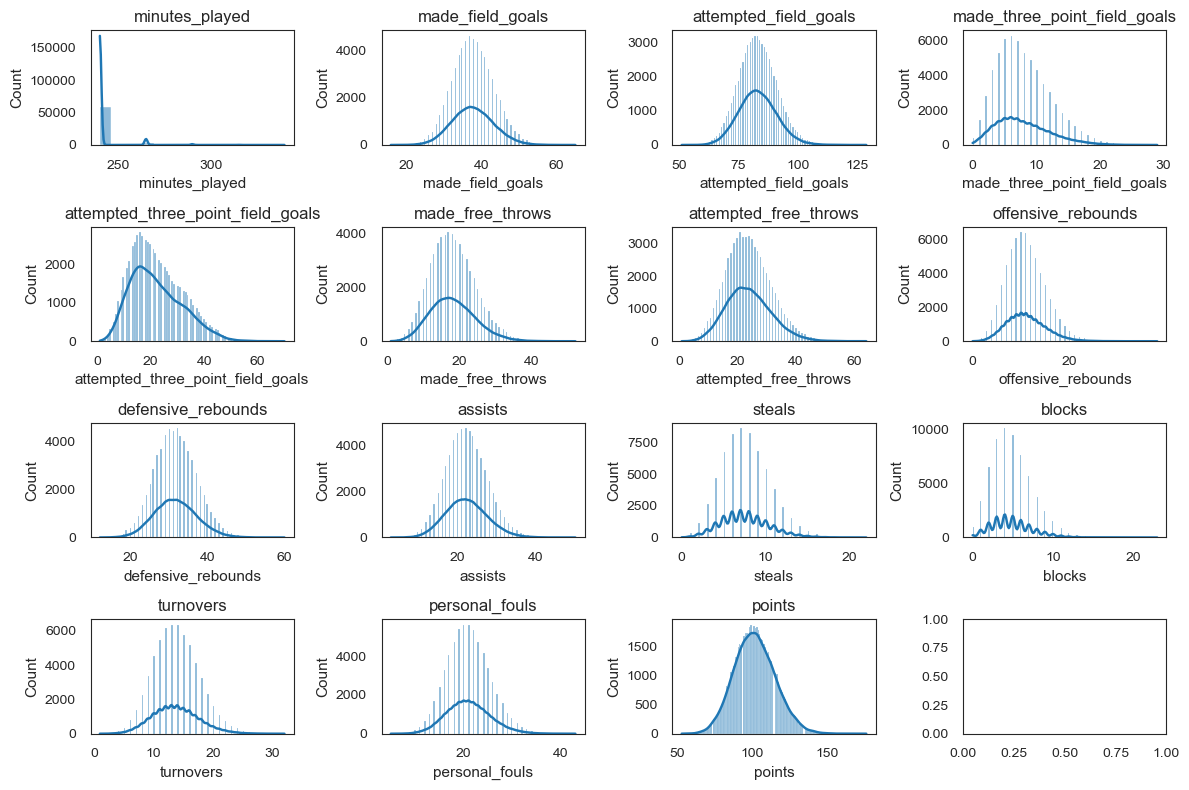

In [57]:
# histograms for each numeric column
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for ax, column in zip(axes.flatten(), int_vars_team_bs):
    sns.histplot(team_bs_df[column], kde=True, ax=ax) 
    ax.set_title(f'{column}')
plt.tight_layout();

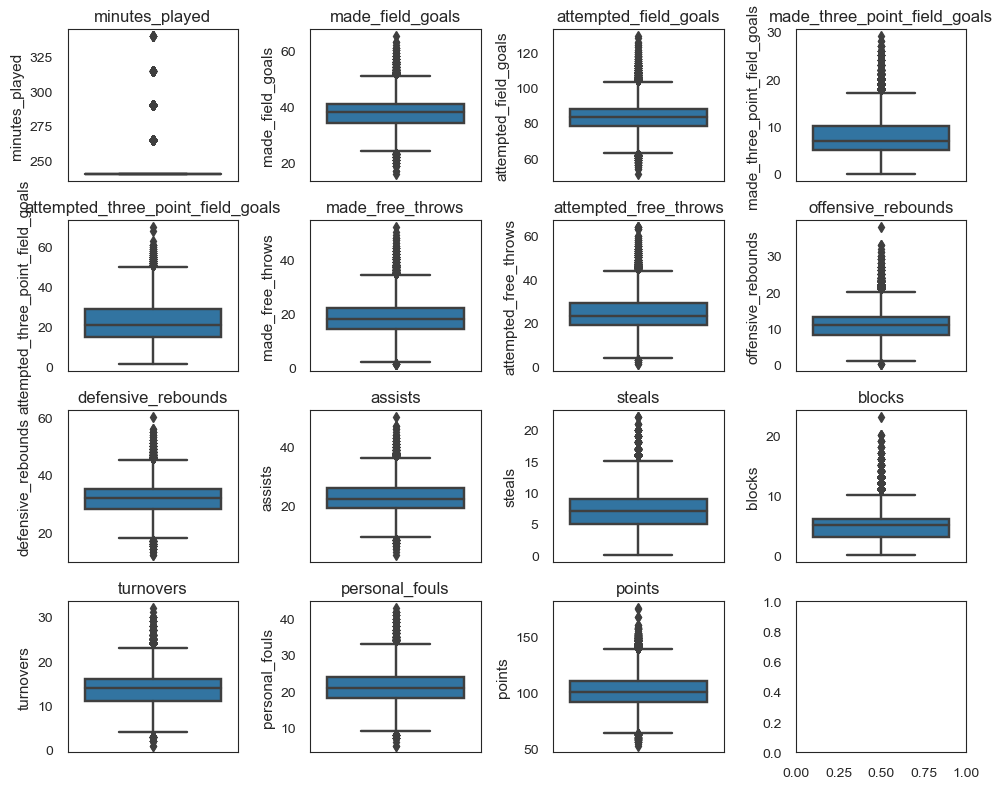

In [58]:
# boxplots for each numeric column
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
for ax, column in zip(axes.flatten(), int_vars_team_bs):
    sns.boxplot(y=column, data=team_bs_df, ax=ax)
    ax.set_title(f'{column}')
plt.tight_layout();

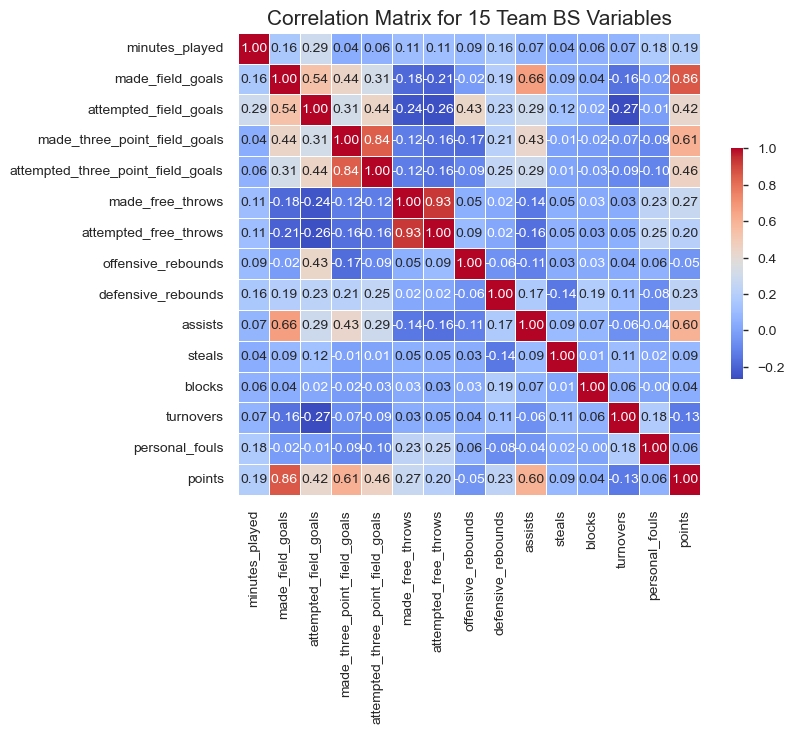

In [72]:
# correlations
plt.figure(figsize=(8, 6))
sns.heatmap(team_bs_df[int_vars_team_bs].corr(), annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for 15 Team BS Variables', fontsize=15);

## Player Box Scores (2000-2024)

In [60]:
player_bs_df = pd.read_csv('../data/original/br_player_box_scores_2000_2024.csv')

In [61]:
player_bs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637201 entries, 0 to 637200
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   date                               637201 non-null  object 
 1   slug                               637201 non-null  object 
 2   name                               637201 non-null  object 
 3   team                               637201 non-null  object 
 4   location                           637201 non-null  object 
 5   opponent                           637201 non-null  object 
 6   outcome                            637201 non-null  object 
 7   seconds_played                     637201 non-null  int64  
 8   made_field_goals                   637201 non-null  int64  
 9   attempted_field_goals              637201 non-null  int64  
 10  made_three_point_field_goals       637201 non-null  int64  
 11  attempted_three_point_field_goals  6372

In [62]:
player_bs_df.head()

,date,slug,name,team,location,opponent,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,game_score
0,2000-01-02,lenarvo01,Voshon Lenard,Miami Heat,Home,Orlando Magic,Win,1833,9,12,3,6,3,3,1,0,3,0,0,1,6,18.6
1,2000-01-02,cartean01,Anthony Carter,Miami Heat,Home,Orlando Magic,Win,2385,4,9,1,1,4,4,1,2,10,3,0,3,3,15.4
2,2000-01-02,majerda01,Dan Majerle,Miami Heat,Home,Orlando Magic,Win,2255,4,7,3,6,2,2,0,6,0,4,0,1,2,13.7
3,2000-01-02,mashbja01,Jamal Mashburn,Miami Heat,Home,Orlando Magic,Win,2359,9,22,1,6,3,4,2,8,4,2,0,4,2,13.6
4,2000-01-02,mournal01,Alonzo Mourning,Miami Heat,Home,Orlando Magic,Win,2559,4,18,0,0,13,17,2,2,3,0,7,2,5,13.4


In [63]:
player_bs_df.describe()

,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,game_score
count,637201.000,637201.000,637201.000,637201.000,637201.00,637201.000,637201.000,637201.000,637201.000,637201.000,637201.000,637201.000,637201.000,637201.000,637201.000
mean,1402.848,3.657,8.044,0.767,2.15,1.757,2.311,1.062,3.067,2.156,0.731,0.473,1.326,2.027,7.547
std,687.541,3.096,5.826,1.228,2.58,2.386,2.926,1.425,2.717,2.521,0.983,0.883,1.410,1.513,7.299
min,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-11.700
25%,890.000,1.000,3.000,0.000,0.00,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.800
50%,1438.000,3.000,7.000,0.000,1.00,1.000,2.000,1.000,2.000,1.000,0.000,0.000,1.000,2.000,6.100
75%,1953.000,5.000,12.000,1.000,4.00,3.000,4.000,2.000,4.000,3.000,1.000,1.000,2.000,3.000,11.800
max,3898.000,28.000,50.000,14.000,24.00,26.000,39.000,18.000,25.000,25.000,10.000,12.000,14.000,6.000,63.500


In [64]:
# missing values table
utl.get_missing_values(player_bs_df)

,Missing Values,% of Total Values


In [66]:
# get numeric variables
int_vars_player_bs = player_bs_df.select_dtypes(include=['int64', 'float64']).columns
print('Number of integer variables:', len(int_vars_player_bs))

Number of integer variables: 15


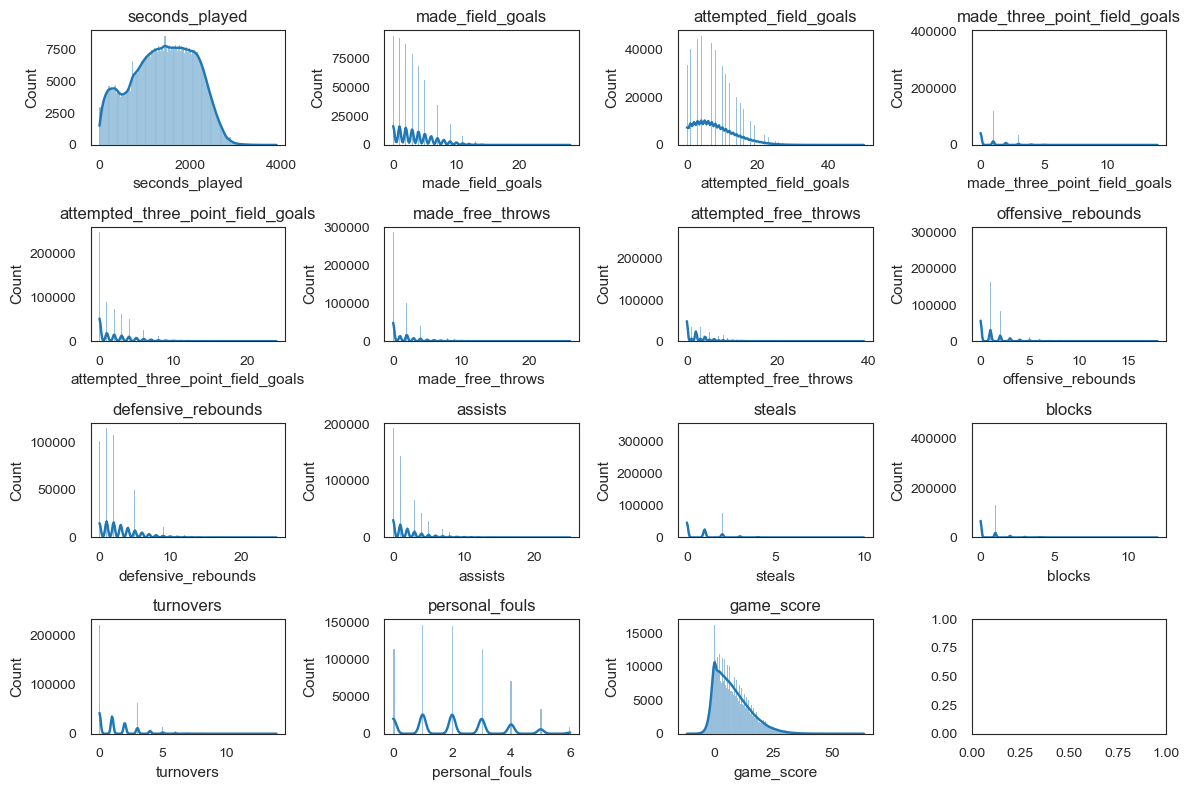

In [68]:
# histograms for each numeric column
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for ax, column in zip(axes.flatten(), int_vars_player_bs):
    sns.histplot(player_bs_df[column], kde=True, ax=ax) 
    ax.set_title(f'{column}')
plt.tight_layout();

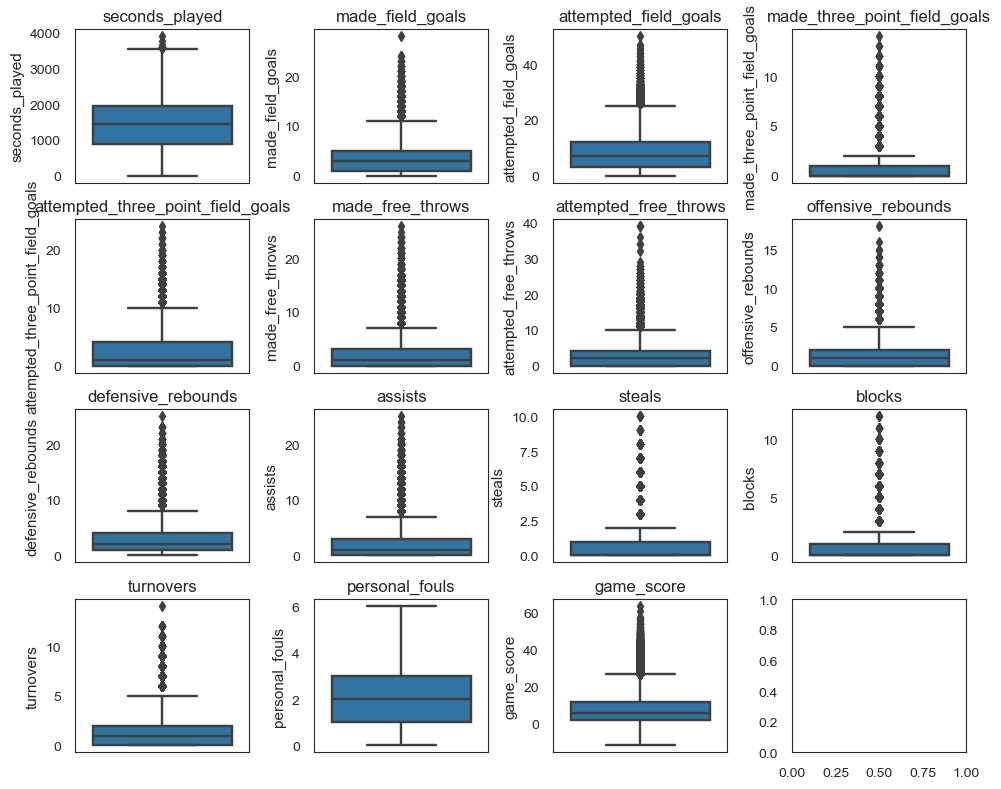

In [69]:
# boxplots for each numeric column
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
for ax, column in zip(axes.flatten(), int_vars_player_bs):
    sns.boxplot(y=column, data=player_bs_df, ax=ax)
    ax.set_title(f'{column}')
plt.tight_layout();

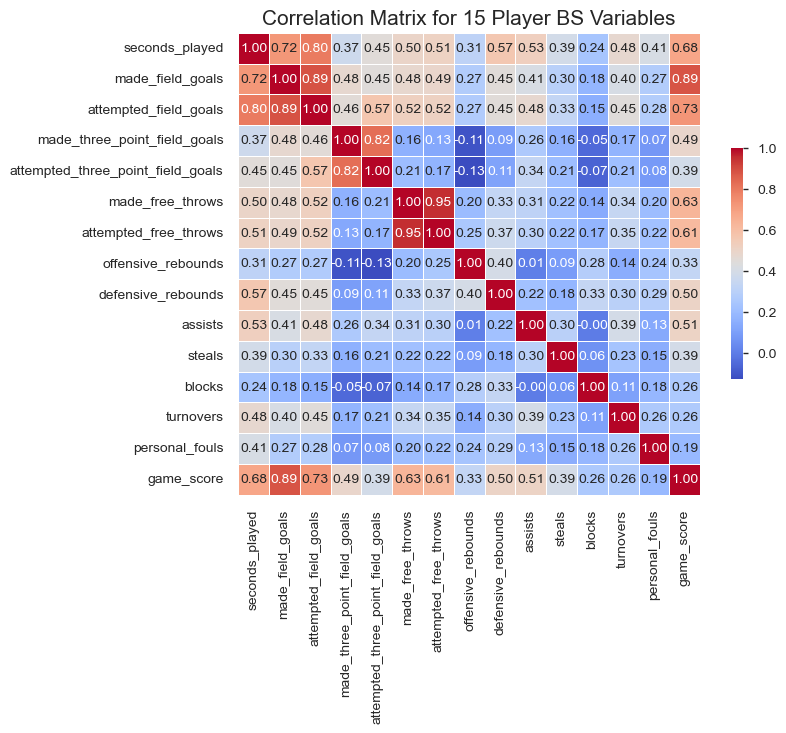

In [71]:
# correlations
plt.figure(figsize=(8, 6))
sns.heatmap(player_bs_df[int_vars_player_bs].corr(), annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for 15 Player BS Variables', fontsize=15);

## Create Targets

### Game Winner

This is just `team_bs_df['outcome']`.

### Total Points (over / under)

This is `team_bs_df['points']`, but we need to sum the points for both teams in the matchup using `schedule_df`.

### Spread

This is `team_bs_df['points']`, but we need to take the delta between teams in a given matchup using `schedule_df`.